In [1]:
!uname -a

Linux compute-0-14.local 2.6.32-642.el6.x86_64 #1 SMP Tue May 10 17:27:01 UTC 2016 x86_64 x86_64 x86_64 GNU/Linux


In [2]:
!pwd

/home/tallam/plasticc/snmachine/examples


In [3]:
!pip install ../.

Processing /home/tallam/plasticc/snmachine
  Running setup.py bdist_wheel for snmachine ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-pwbkmss9/wheels/cd/65/db/fda56ff3f0d6fa8ba1e7b69dab8a17be3a2bbe7940a42d6151
Successfully built snmachine
  Found existing installation: snmachine 1.1.1
    Uninstalling snmachine-1.1.1:
      Successfully uninstalled snmachine-1.1.1


# Notebook for running the snmachine pipeline on PLAsTiCC simulated data

This notebook illustrates the use of the `snmachine` supernova classification package by classifying a subset simulated data from the photometric light-curve astronomical time-series classification challenge (PLAsTiCC). 

See Lochner et al. (2016) http://arxiv.org/abs/1603.00882 for the original SPCC-challenge test.

<img src="pipeline.png" width=600>

This image illustrates the how the pipeline works. As the user, you can choose what feature extraction method you want to use. Here we have three (four, technically, since there are two parametric models) but it's straighforward to write a new feature extraction method. Once features have been extracted, they can be run through one of several machine learning algorithms and again, it's easy to write your own algorithm into the pipeline. There's a convenience function in `snclassifier` to run a feature set through multiple algorithms and plot the result. The rest of this notebook goes through applying each of the feature extraction methods to a set of simulations and running all feature sets through different classification algorithms.

In [4]:
%%capture --no-stdout 
#I use this to supress unnecessary warnings for clarity
%load_ext autoreload
%autoreload #Use this to reload modules if they are changed on disk while the notebook is running
from snmachine import sndata, snfeatures, snclassifier, tsne_plot
import numpy as np
import matplotlib.pyplot as plt
import time, os, pywt,subprocess
from sklearn.decomposition import PCA
from astropy.table import Table,join,vstack
from astropy.io import fits
import sklearn.metrics 
import sncosmo
import pickle
%matplotlib nbagg

In [5]:
%load_ext autoreload
%autoreload #Use this to reload modules if they are changed on disk while the notebook is running

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Set the number of processes you want to use throughout the notebook
import multiprocessing
num_cpu = multiprocessing.cpu_count()
nproc=num_cpu
print("Running with {} cores".format(num_cpu))

Running with 24 cores


In [7]:
# # Set the number of processes you want to use throughout the notebook
# nproc=40
# # Also please specify Data root, 
# # the path to where you have pulled all the data from
# rt='/share/hypatia/snmachine_resources/data/plasticc'
# #rt=os.path.join('/Users/cnsetzer/software/data/plasticc_all','')

## Set up output structure

We make lots of output files so it makes sense to put them in one place. This is the recommended output file structure.

In [8]:
rt='/share/hypatia/snmachine_resources/data/plasticc'

In [9]:
dataset='plasticc'

In [74]:
# WARNING...
#Multinest uses a hardcoded character limit for the output file names. I believe it's a limit of 100 characters
#so avoid making this file path to lengthy if using nested sampling or multinest output file names will be truncated

#Change outdir to somewhere on your computer if you like
outdir="/share/hypatia/snmachine_resources/data/plasticc/output_{}_no_z/".format(dataset)
#outdir=os.path.join('output_{}_no_z'.format(dataset),'')
out_features=os.path.join(outdir,'features') #Where we save the extracted features to
out_class=os.path.join(outdir,'classifications') #Where we save the classification probabilities and ROC curves
out_int=os.path.join(outdir,'int') #Any intermediate files (such as multinest chains or GP fits)
out_plots=os.path.join(outdir,'plots')

subprocess.call(['mkdir',outdir])
subprocess.call(['mkdir',out_features])
subprocess.call(['mkdir',out_class])
subprocess.call(['mkdir',out_int])
subprocess.call(['mkdir',out_plots])

0

## Initialise dataset object

Load a subset of the PLAsTiCC simulated data (https://arxiv.org/abs/1810.00001)

In [11]:
dat=sndata.PlasticcData(folder=rt,data_file='training_set.csv',meta_file='training_set_metadata.csv',from_pickle=False)
#dat=sndata.plasticc_data(folder=rt,pickle_file='dataset_full.pickle',from_pickle=True)

Reading data...
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
7848 objects read into memory.
Reading metadata...
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
Finished getting the metadata for 7848k objects.

This has taken 0:02:34


In [12]:
# Get the types, note these are internal snmachine datatypes
types=dat.get_types()

Now we can plot all the data and cycle through it (left and right arrows on your keyboard)

<IPython.core.display.Javascript object>


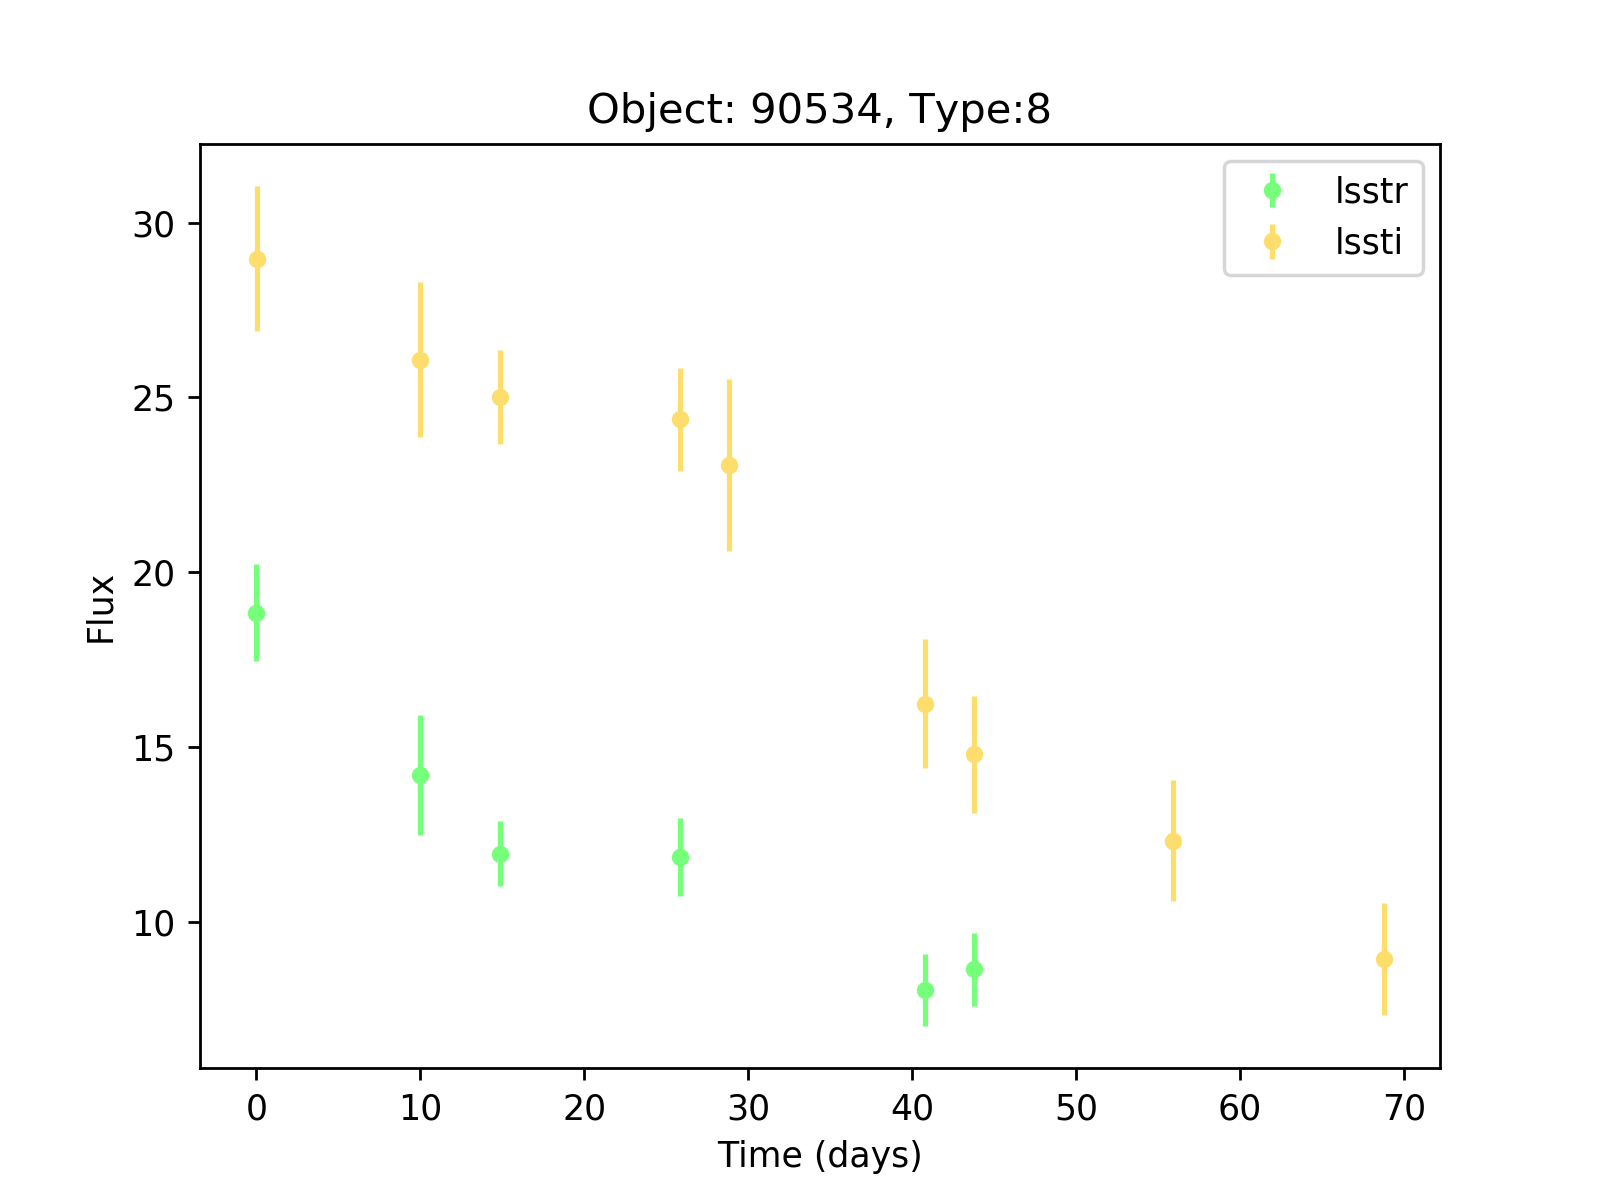

In [13]:
dat.plot_all(mix=True)

Each light curve is represented in the Dataset object as an astropy table, compatible with `sncosmo`:

Note: The types listed here in the table the internal types to snmachine

In [14]:
dat.data[dat.object_names[0]]

object_id,mjd,filter,flux,flux_error,detected
int64,float64,str5,float64,float64,int64
61866802,0.0,lssti,76.419876,7.37994,1
61866802,1.0378,lssti,82.712189,5.28241,1
61866802,6.9875,lssty,119.441154,21.329971,1
61866802,8.14,lsstz,122.952934,21.521608,1
61866802,43.8637,lsstz,92.354729,8.981542,1
61866802,60.9792,lsstz,52.861656,11.762576,1


In [15]:
# objData = dat.data[dat.object_names[0]]
# objData[objData['detected']==1]

## Extract features for the data

The next step is to extract useful features from the data. This can often take a long time, depending on the feature extraction method, so it's a good idea to save these to file (`snmachine` by default saves to astropy tables)

### Inspect GP fitting capability for individual objects first

<IPython.core.display.Javascript object>


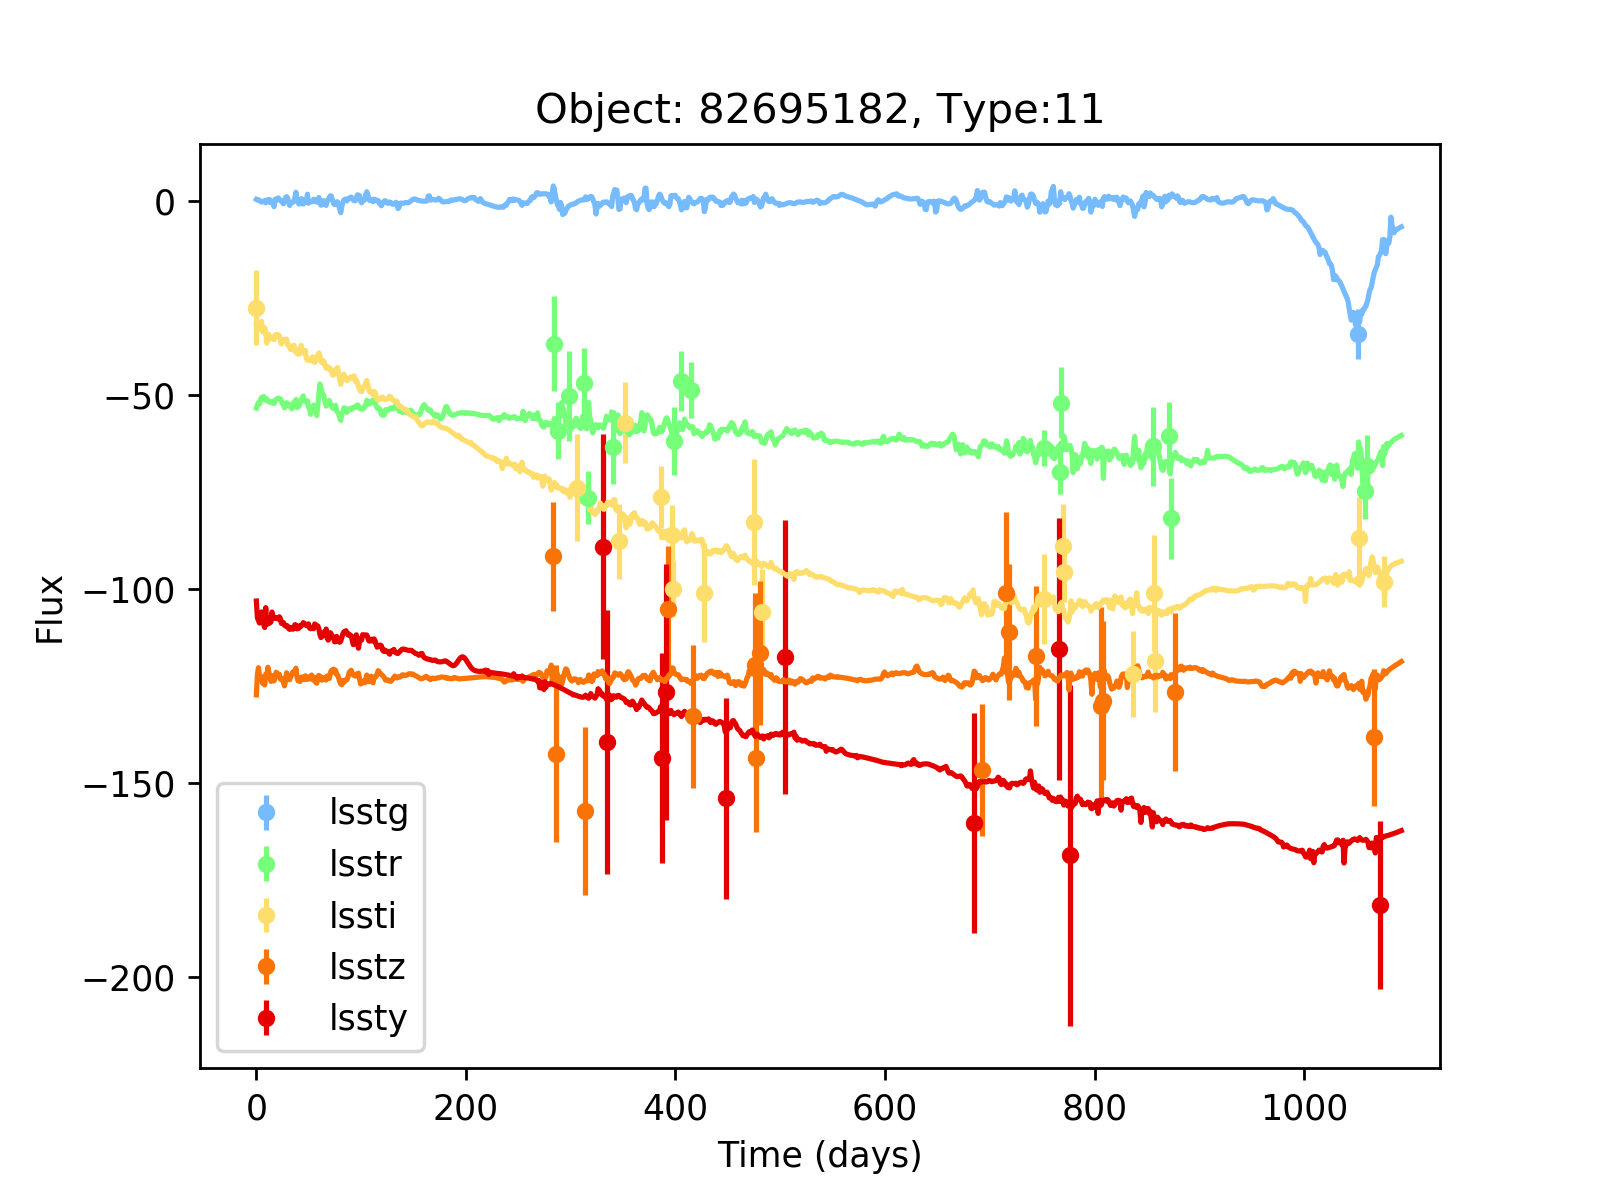

In [127]:
# Choose a random object to inspect
test_obj = dat.object_names[1101]
print(type(test_obj))
plt.figure()
dat.plot_lc(test_obj, plot_model=True)

<IPython.core.display.Javascript object>


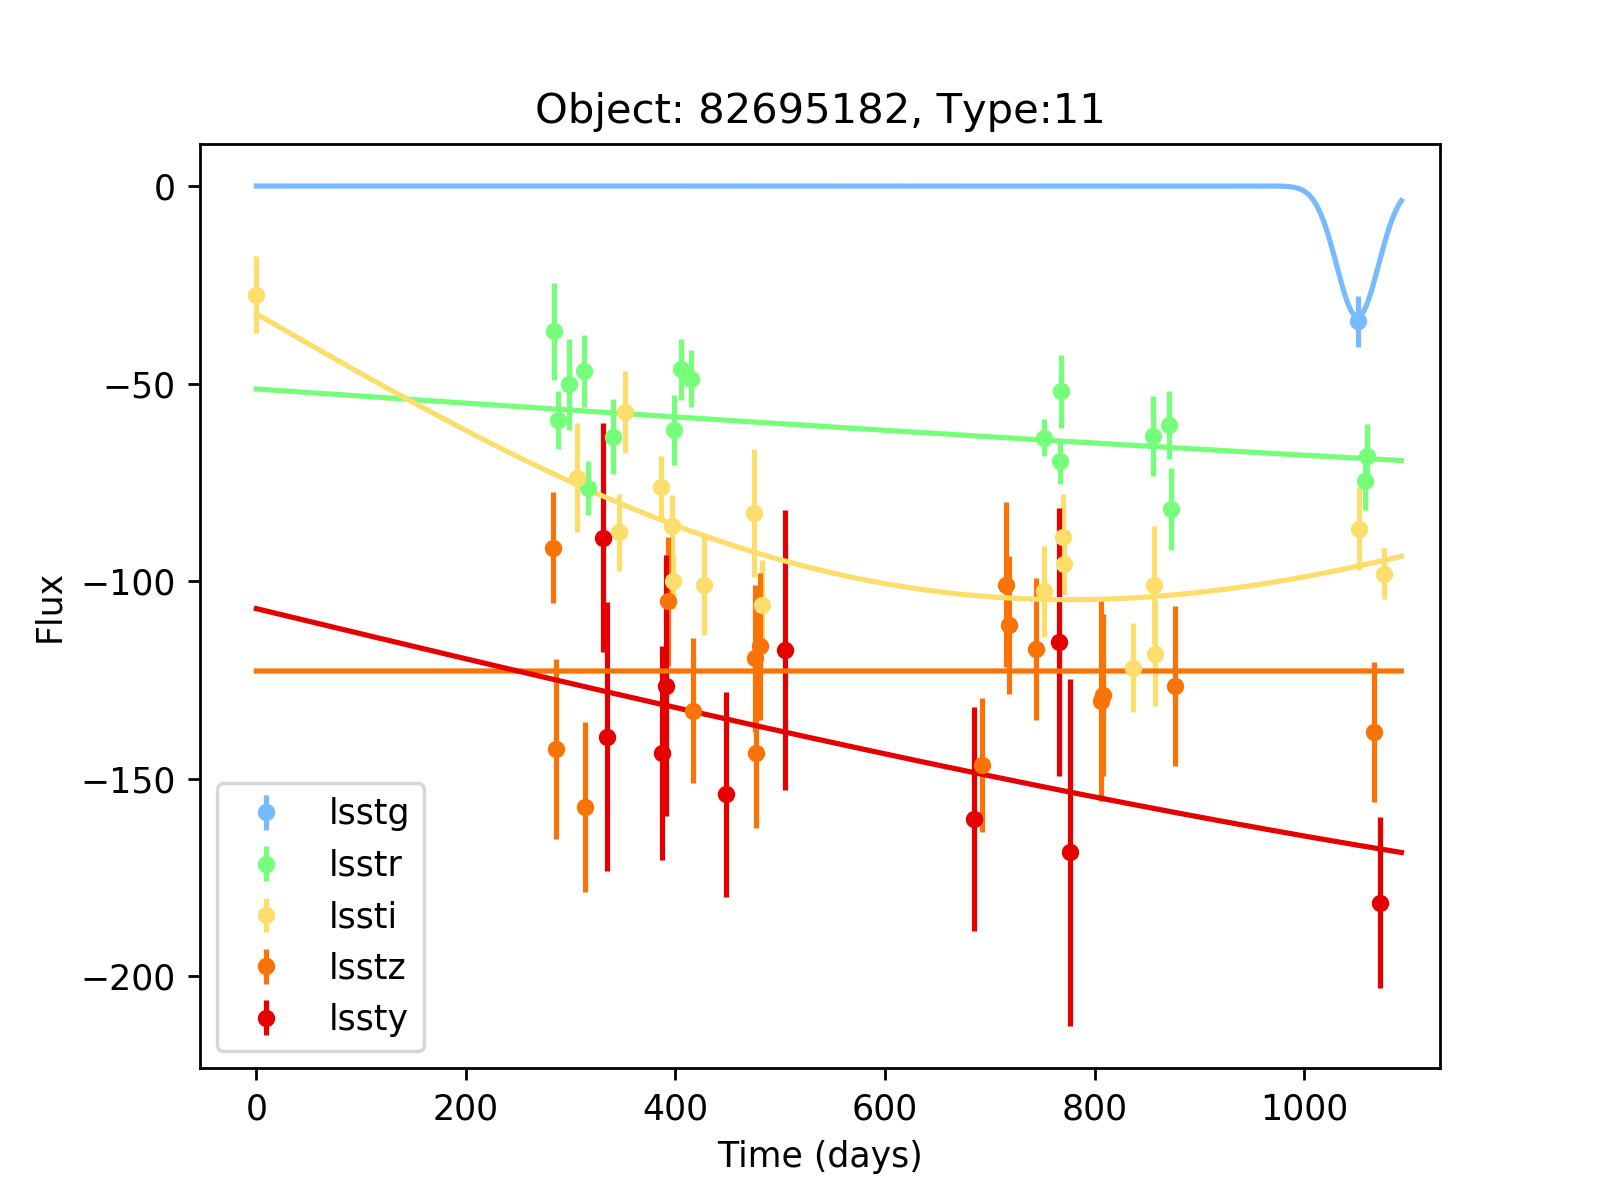

In [128]:
#sn = dat.data[test_obj]
g=snfeatures._GP(test_obj, dat,ngp=1100,xmin=0,xmax=dat.get_max_length(),initheta=[500,20], save_output=True, output_root=out_int)
dat.models[test_obj] = g
type(dat)
#dat.plot_lc(test_obj, plot_model=True)
plt.figure()
dat.plot_lc(test_obj, plot_model=True)

In [21]:
read_from_file=False #We can use this flag to quickly rerun from saved features
run_name=os.path.join(out_features,'{}_all'.format(dataset))
read_from_pickle=False
pickle_location = rt
restart_from_GP = False
restart_from_wavefeats=False

### Wavelet features

The wavelet feature extraction process is quite complicated, although it is fairly fast. Remember to save the PCA eigenvalues, vectors and mean for later reconstruction!

In [22]:
#rt='/share/hypatia/snmachine_resources/data/plasticc/data_products/plasticc_training/without_seasongap_cutting/features/'

In [ ]:
#waveFeats=snfeatures.WaveletFeatures()
#waveFeats=snfeatures.WaveletFeatures()
wavelet_feats=snfeatures.WaveletFeatures(wavelet='sym2', ngp=1100)

In [24]:
#%%capture --no-stdout
if read_from_file:
    wave_features=Table.read('%s_wavelets.dat' %run_name, format='ascii')
    #Crucial for this format of id's
    blah=wave_features['Object'].astype(str)
    wave_features.replace_column('Object', blah)
    PCA_vals=np.loadtxt('%s_wavelets_PCA_vals.dat' %run_name)
    PCA_vec=np.loadtxt('%s_wavelets_PCA_vec.dat' %run_name)
    PCA_mean=np.loadtxt('%s_wavelets_PCA_mean.dat' %run_name)
elif read_from_pickle:
    print('THIS IS NOT CURRENTLY IMPLEMENTED')
    f = open(rt)
    wave_features=Table.read('%s_wavelets.dat' %run_name, format='ascii')
    #Crucial for this format of id's
    blah=wave_features['Object'].astype(str)
    wave_features.replace_column('Object', blah)
    PCA_vals=np.loadtxt('%s_wavelets_PCA_vals.dat' %run_name)
    PCA_vec=np.loadtxt('%s_wavelets_PCA_vec.dat' %run_name)
    PCA_mean=np.loadtxt('%s_wavelets_PCA_mean.dat' %run_name)
elif restart_from_GP:
    wave_features=waveFeats.extract_features(dat,nprocesses=nproc,output_root=rt,save_output='all',restart='gp')
    wave_features.write('%s_wavelets.dat' %run_name, format='ascii')
    np.savetxt('%s_wavelets_PCA_vals.dat' %run_name,waveFeats.PCA_eigenvals)
    np.savetxt('%s_wavelets_PCA_vec.dat' %run_name,waveFeats.PCA_eigenvectors)
    np.savetxt('%s_wavelets_PCA_mean.dat' %run_name,waveFeats.PCA_mean)
    
    PCA_vals=waveFeats.PCA_eigenvals
    PCA_vec=waveFeats.PCA_eigenvectors
    PCA_mean=waveFeats.PCA_mean
    
elif restart_from_wavefeats:
    wave_features=Table.read(rt  + 'wavelet_features.fits',format='fits')
    wave_features.write('%s_wavelets.dat' %run_name, format='ascii')
    f = open(rt+'PCA_eigenvals.pickle','rb')
    PCA_vals=pickle.load(f)
    f.close()
    f = open(rt+'PCA_eigenvectors.pickle','rb')
    PCA_vec=pickle.load(f)
    f.close()
    f = open(rt+'PCA_mean.pickle','rb')
    PCA_mean=pickle.load(f)
    f.close()
    np.savetxt('%s_wavelets_PCA_vals.dat' %run_name,PCA_vals)
    np.savetxt('%s_wavelets_PCA_vec.dat' %run_name,PCA_vec)
    np.savetxt('%s_wavelets_PCA_mean.dat' %run_name,PCA_mean)
    

else:
#     wave_features=waveFeats.extract_features(dat,nprocesses=nproc,output_root=out_int,save_output='all')
#     wave_features.write('%s_wavelets.dat' %run_name, format='ascii')
#     np.savetxt('%s_wavelets_PCA_vals.dat' %run_name,waveFeats.PCA_eigenvals)
#     np.savetxt('%s_wavelets_PCA_vec.dat' %run_name,waveFeats.PCA_eigenvectors)
#     np.savetxt('%s_wavelets_PCA_mean.dat' %run_name,waveFeats.PCA_mean)
    
#     PCA_vals=waveFeats.PCA_eigenvals
#     PCA_vec=waveFeats.PCA_eigenvectors
#     PCA_mean=waveFeats.PCA_mean
    
    wavelet_features=wavelet_feats.extract_features(dat,nprocesses=nproc,output_root=out_int,save_output='all', xmax=1100)
    wavelet_features.write('%s_wavelets.dat' %run_name, format='ascii')
    np.savetxt('%s_wavelets_PCA_vals.dat' %run_name,wavelet_feats.PCA_eigenvals)
    np.savetxt('%s_wavelets_PCA_vec.dat' %run_name,wavelet_feats.PCA_eigenvectors)
    np.savetxt('%s_wavelets_PCA_mean.dat' %run_name,wavelet_feats.PCA_mean)
    
    vals=wavelet_feats.PCA_eigenvals
    vec=wavelet_feats.PCA_eigenvectors
    means=wavelet_feats.PCA_mean

/home/tallam/.conda/envs/snmplasticc/lib/python3.6/site-packages/astropy/table/table.py:2622: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


In [112]:
maxlen = dat.get_max_length()
maxlen

1092.8453000000009

In [25]:
#dat.set_model(waveFeats.fit_sn,wave_features,PCA_vec,PCA_mean,0,dat.get_max_length(),dat.filter_set)
# dat.set_model(wavelet_feats.fit_sn,wavelet_features,vec,means,0,dat.get_max_length(),dat.filter_set)

<IPython.core.display.Javascript object>


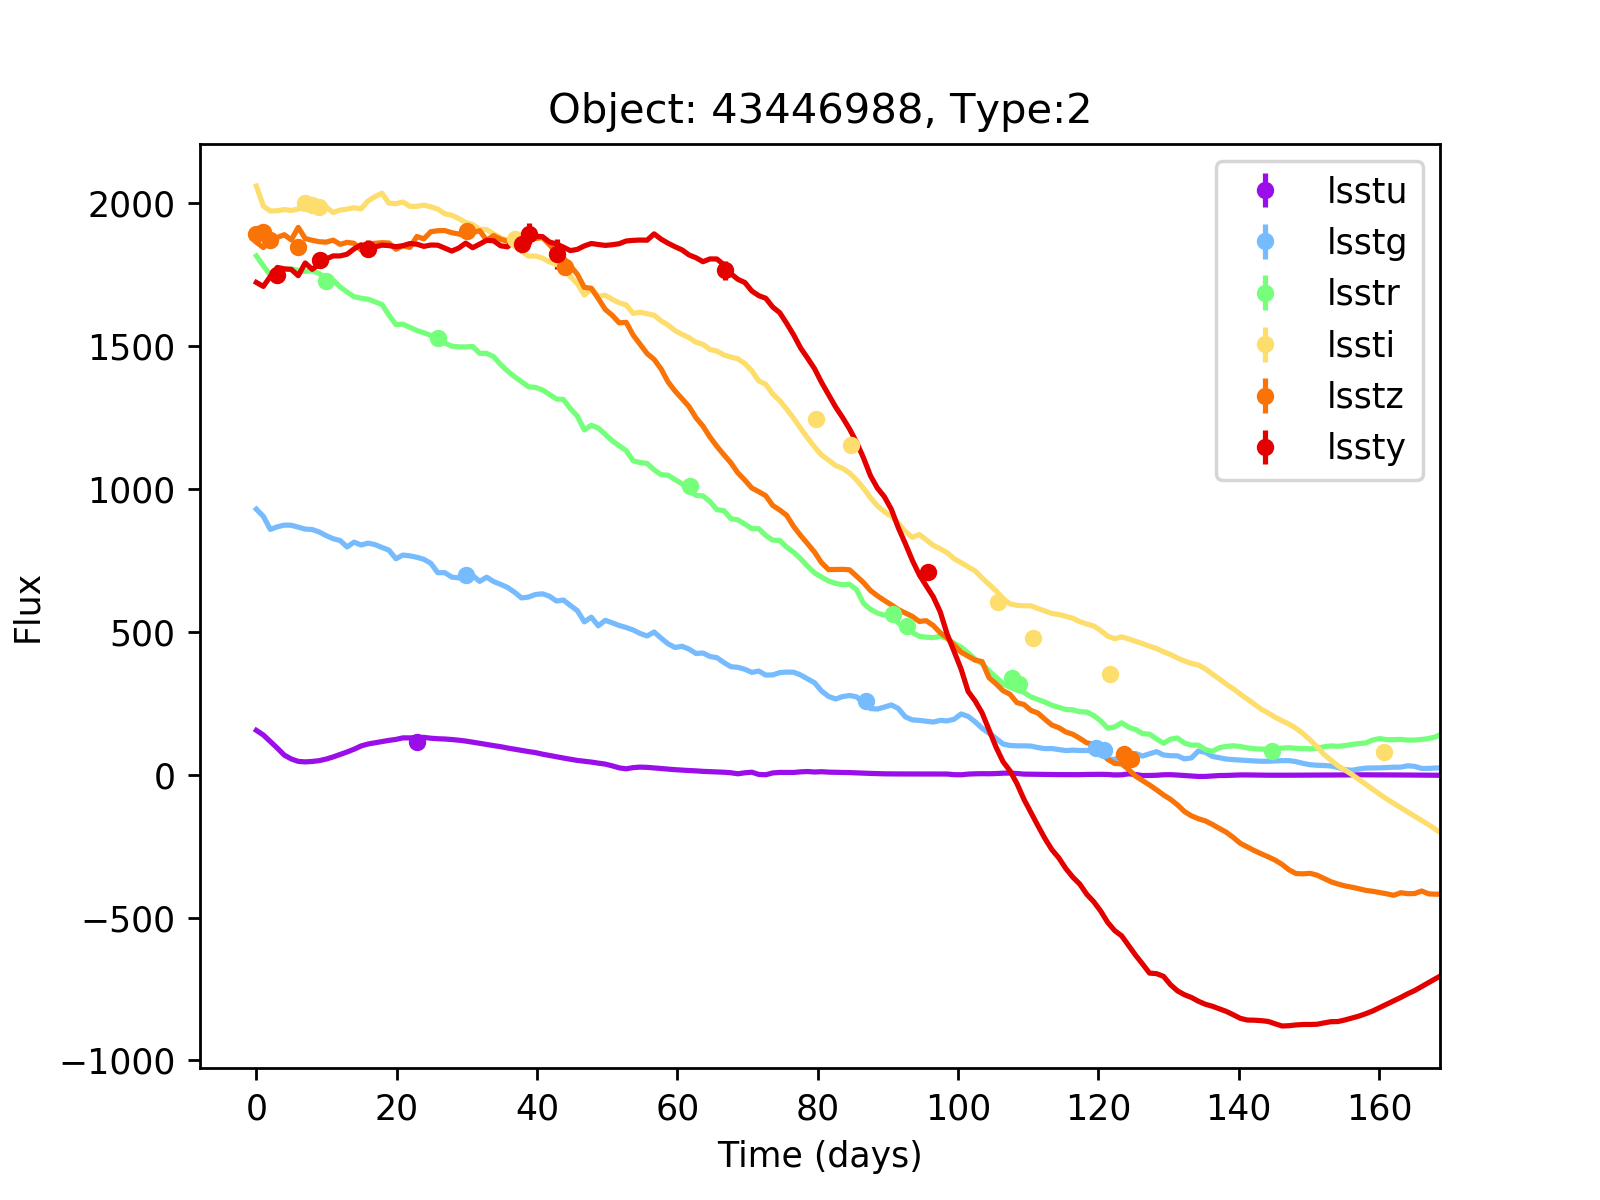

In [111]:
dat.plot_all(mix=True)

### Chi Squared Histogram

We want to double check the GP's have been fit well.

In [32]:
training_objects = list(dat.object_names[:])

In [33]:
chi_dict = dat.reduced_chi_squared(training_objects)
chi_dict

{'11914968': 0.63010264764189927,
 '93271095': 328.15750842461875,
 '59463': 1.0959971492063769,
 '20332012': 0.20383472847180403,
 '70171': 2.1140565563484963,
 '51571190': 0.54845126844917746,
 '47510014': 0.17015572422667335,
 '329277': 1.7317975530687955,
 '152425': 65.35525221637343,
 '38591698': 5.7979405720031849,
 '113851505': 91.69445989591685,
 '71843921': 0.52381995269655057,
 '14904492': 0.48542693912151541,
 '84680127': 0.64148608386885775,
 '334262': 4.0246007170445388,
 '5265524': 20.707506797045191,
 '28823679': 0.99046767358701371,
 '35947297': 4.2364968814528039,
 '115990572': 685.96985408125124,
 '91932161': 166.68643684855843,
 '95880277': 0.28644213851292977,
 '42224': 0.74841572497360331,
 '331174': 232.82352629100237,
 '35555': 4.2975040833399074,
 '335454': 12.359520985575815,
 '87240115': 0.33151200815100529,
 '63799162': 0.20402078231150911,
 '74733910': 0.9526293208692157,
 '89682257': 0.1200872216211557,
 '80261729': 2.0530659865438237,
 '55439147': 2.557674

<IPython.core.display.Javascript object>


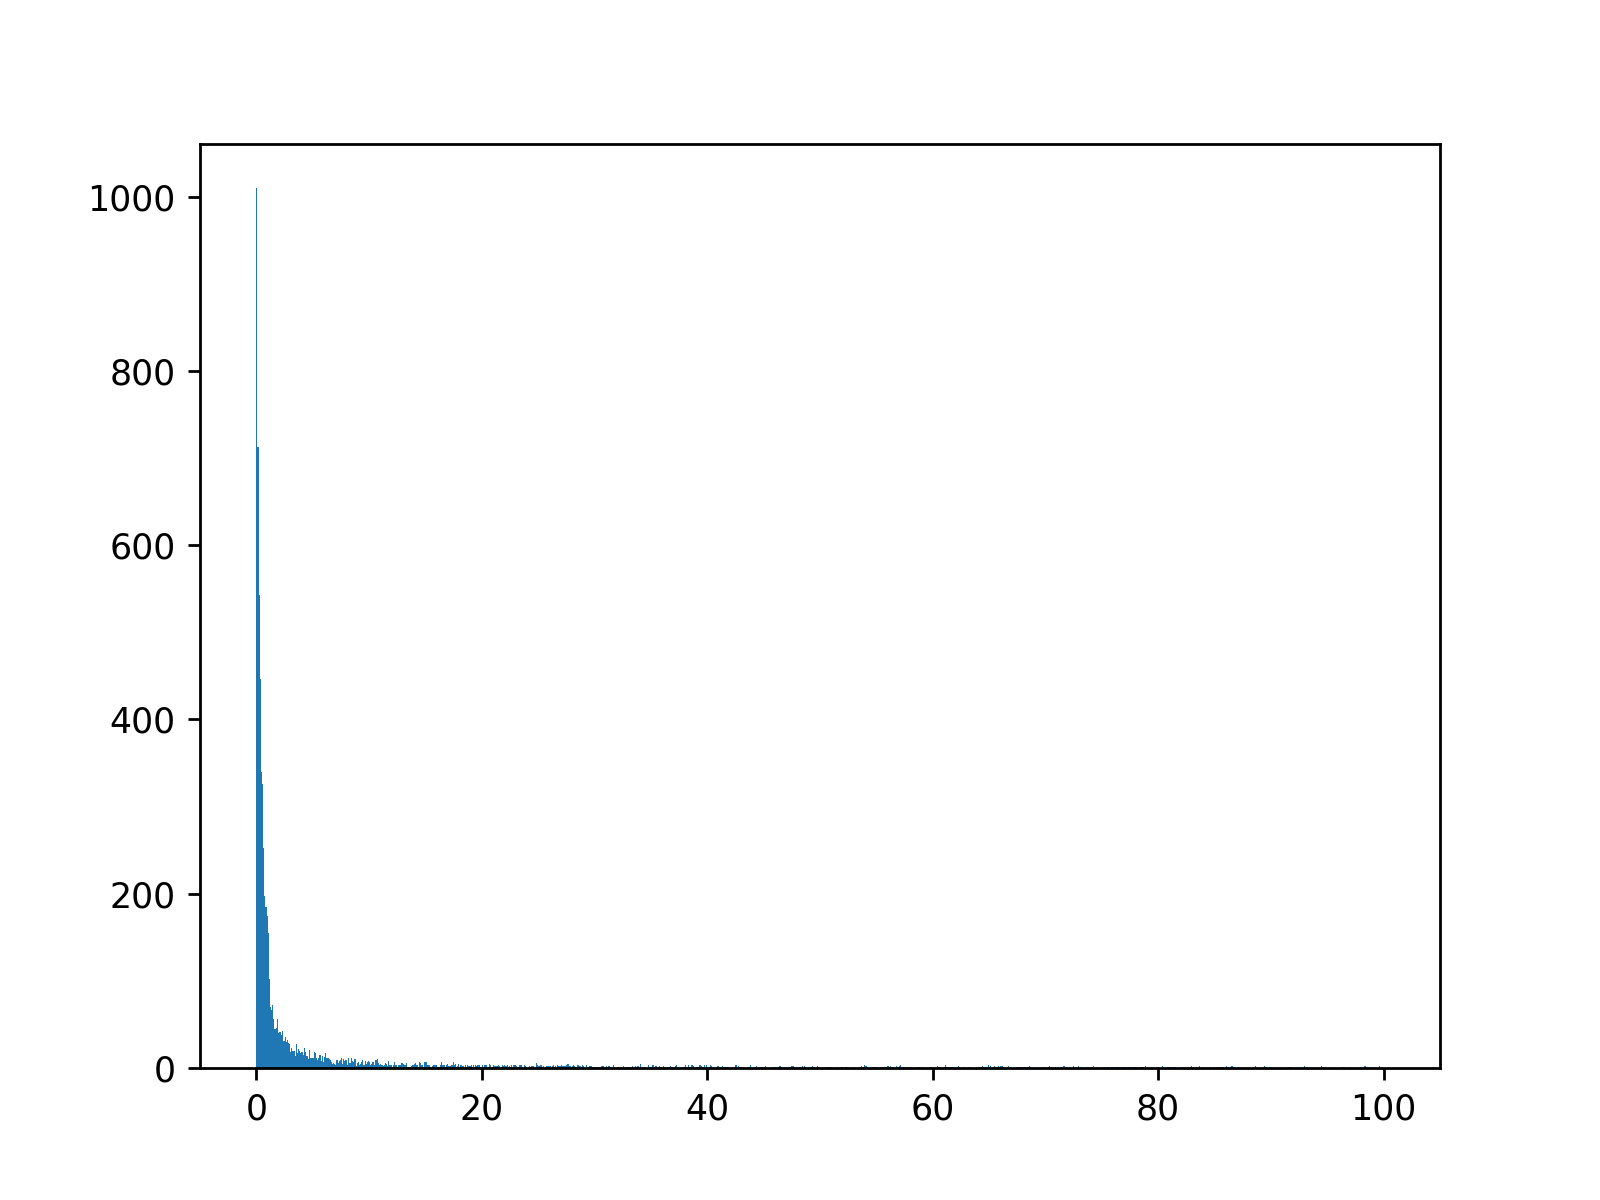

In [35]:
plt.figure(99)
plt.hist(chi_dict.values(), bins=1000, range=(0.0, 100))
plt.show()

In [94]:
typespd = types.to_pandas()
typespd.head()

,Object,Type
0,11914968,11
1,93271095,5
2,59463,2
3,20332012,1
4,70171,3


In [106]:
# typespd.replace({"Type": d})
type(typespd.Type.map(d))
# typespd.Type.map(d)
newcol = typespd.Type.map(d)
typespd.update(newcol)

In [108]:
types = Table.from_pandas(typespd)
types

Object,Type
str9,int64
11914968,6
93271095,16
59463,42
20332012,88
70171,90
51571190,62
47510014,67
329277,42
152425,65


<IPython.core.display.Javascript object>


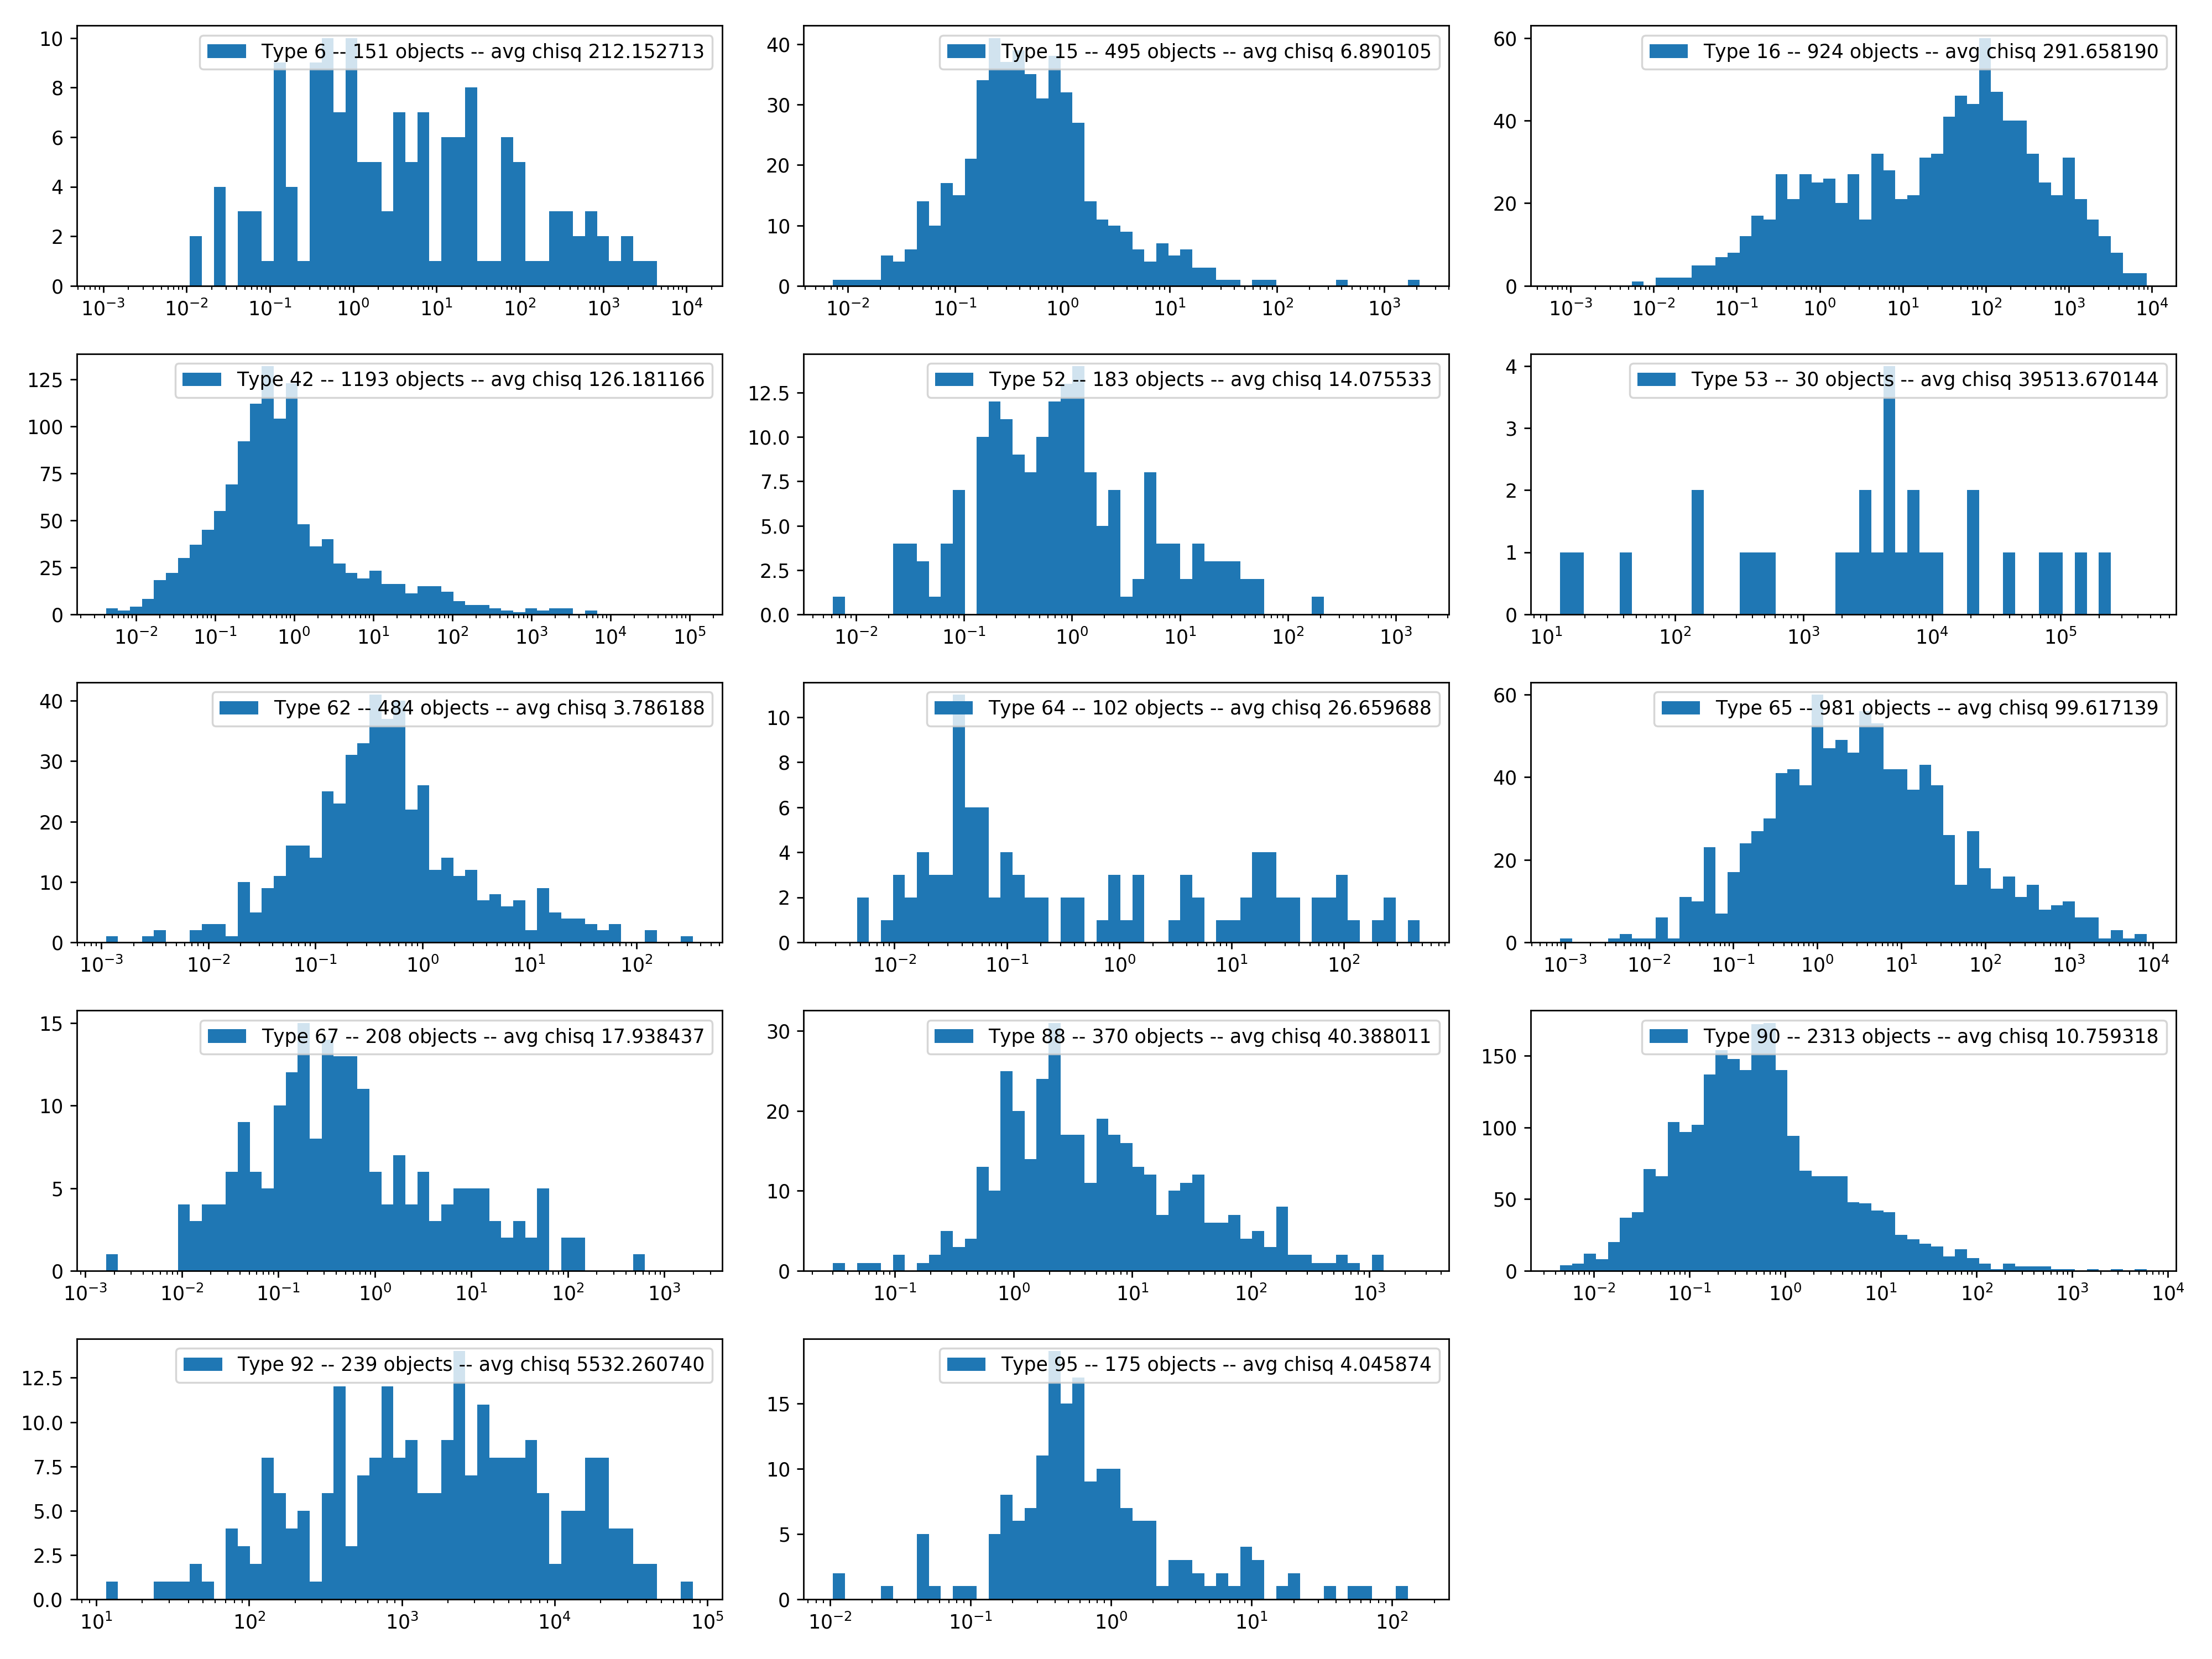

In [109]:
#compute chi2/dof for all objects (summarising all bands into one value)
chisq=dat.reduced_chi_squared()

#divide chisq values by type
# types=dat.get_types()
unique_types=np.unique(types['Type'])
objs_by_types={}
for t in unique_types:
        tlist=types['Object'][types['Type']==t]
        objs_by_types[t]=tlist

#define auxiliary routine that sets up the histogram for each plot
def makeplot(t,ax):
        chisq_t=np.array([chisq[o] for o in objs_by_types[t]])
        mini,maxi=chisq_t.min(),chisq_t.max()
        ax.set_xscale('log')
        ax.hist(chisq_t,bins=np.logspace(np.log10(mini),np.log10(maxi),50),label='Type %s -- %d objects -- avg chisq %f'%(str(t),len(chisq_t), chisq_t.mean()))
        ax.legend()

#plot histograms for each type
fig,axes=plt.subplots(nrows=5,ncols=3,figsize=(16,12))
for i in range(len(unique_types)):
        ax=axes.flatten()[i]
        makeplot(unique_types[i],ax)

#remove last (empty) plot
axes.flatten()[-1].axis('off')
plt.tight_layout()
plt.show()
plt.savefig(out_plots+'/chisq_by_type.png')

In [29]:
d = dat.dict_2_user_types
d = {int(k):int(v) for k,v in d.items()}
d

{0: 92,
 1: 88,
 2: 42,
 3: 90,
 4: 65,
 5: 16,
 6: 67,
 7: 95,
 8: 62,
 9: 15,
 10: 52,
 11: 6,
 12: 64,
 13: 53}

### Plot t-SNE

In [ ]:
# plt.figure()
# tsne_plot.plot(wave_features,join(wave_features,types)['Type'], type_dict=dat.dict_2_user_types)

## Classify

Finally, we're ready to run the machine learning algorithm. There's a utility function in the `snclassifier` library to make it easy to run all the algorithms available, including converting features to `numpy` arrays and rescaling them and automatically generating ROC curves and metrics. Hyperparameters are automatically selected using a grid search combined with cross-validation. All functionality can also be individually run from `snclassifier`.

Classifiers can be run in parallel, change this parameter to the number of processors on your machine (we're only running 4 algorithms so it won't help to set this any higher than 4).

In [30]:
#Available classifiers 
print(snclassifier.choice_of_classifiers)

##### TODO
### Combine further features

<IPython.core.display.Javascript object>


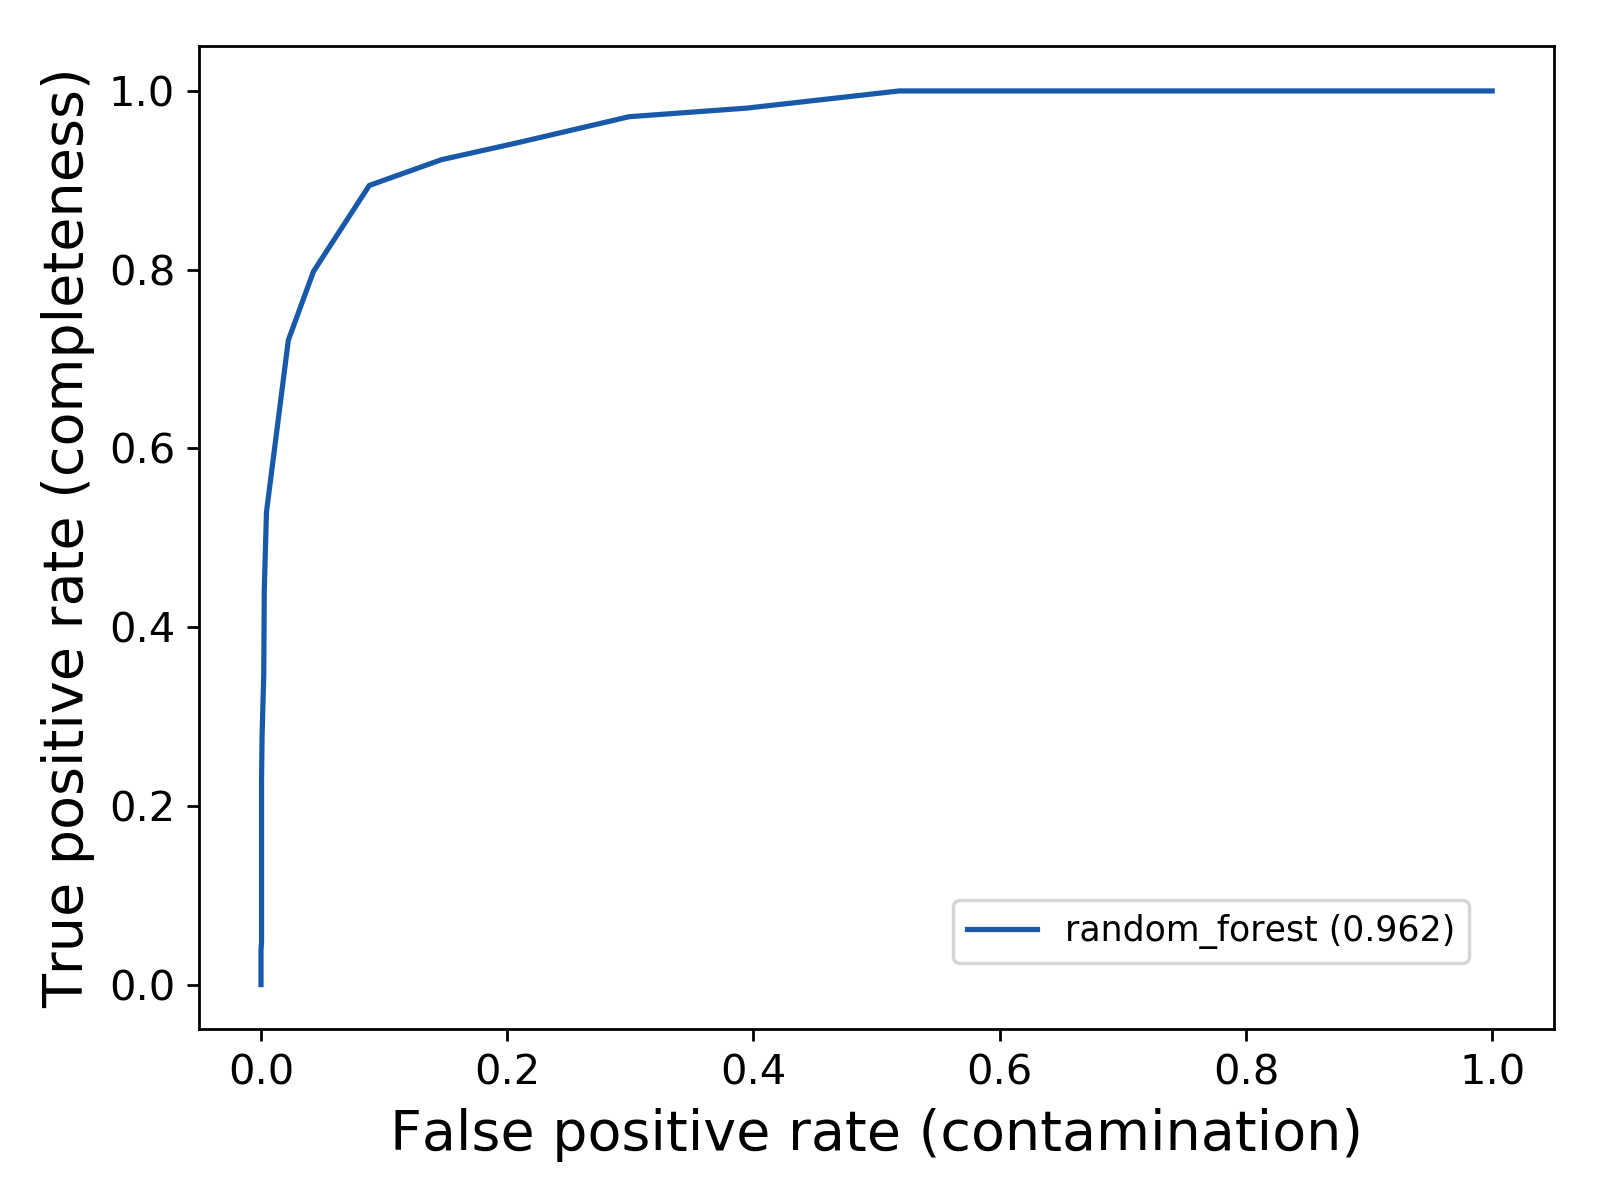

/home/tallam/.conda/envs/snmplasticc/lib/python3.6/site-packages/snmachine/snclassifier.py:130: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  ax.set_color_cycle(cols)


In [36]:
fig = plt.figure()
clss, cms=snclassifier.run_pipeline(wavelet_features,types,output_name=os.path.join(out_class,'wavelets'),
                          training_set=0.7, classifiers=['random_forest'], nprocesses=nproc, 
                            return_classifier=True, classifiers_for_cm_plots='all')

In [37]:
import seaborn as sns
from astropy.table import Table,join,unique

/home/tallam/.conda/envs/snmplasticc/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


<IPython.core.display.Javascript object>


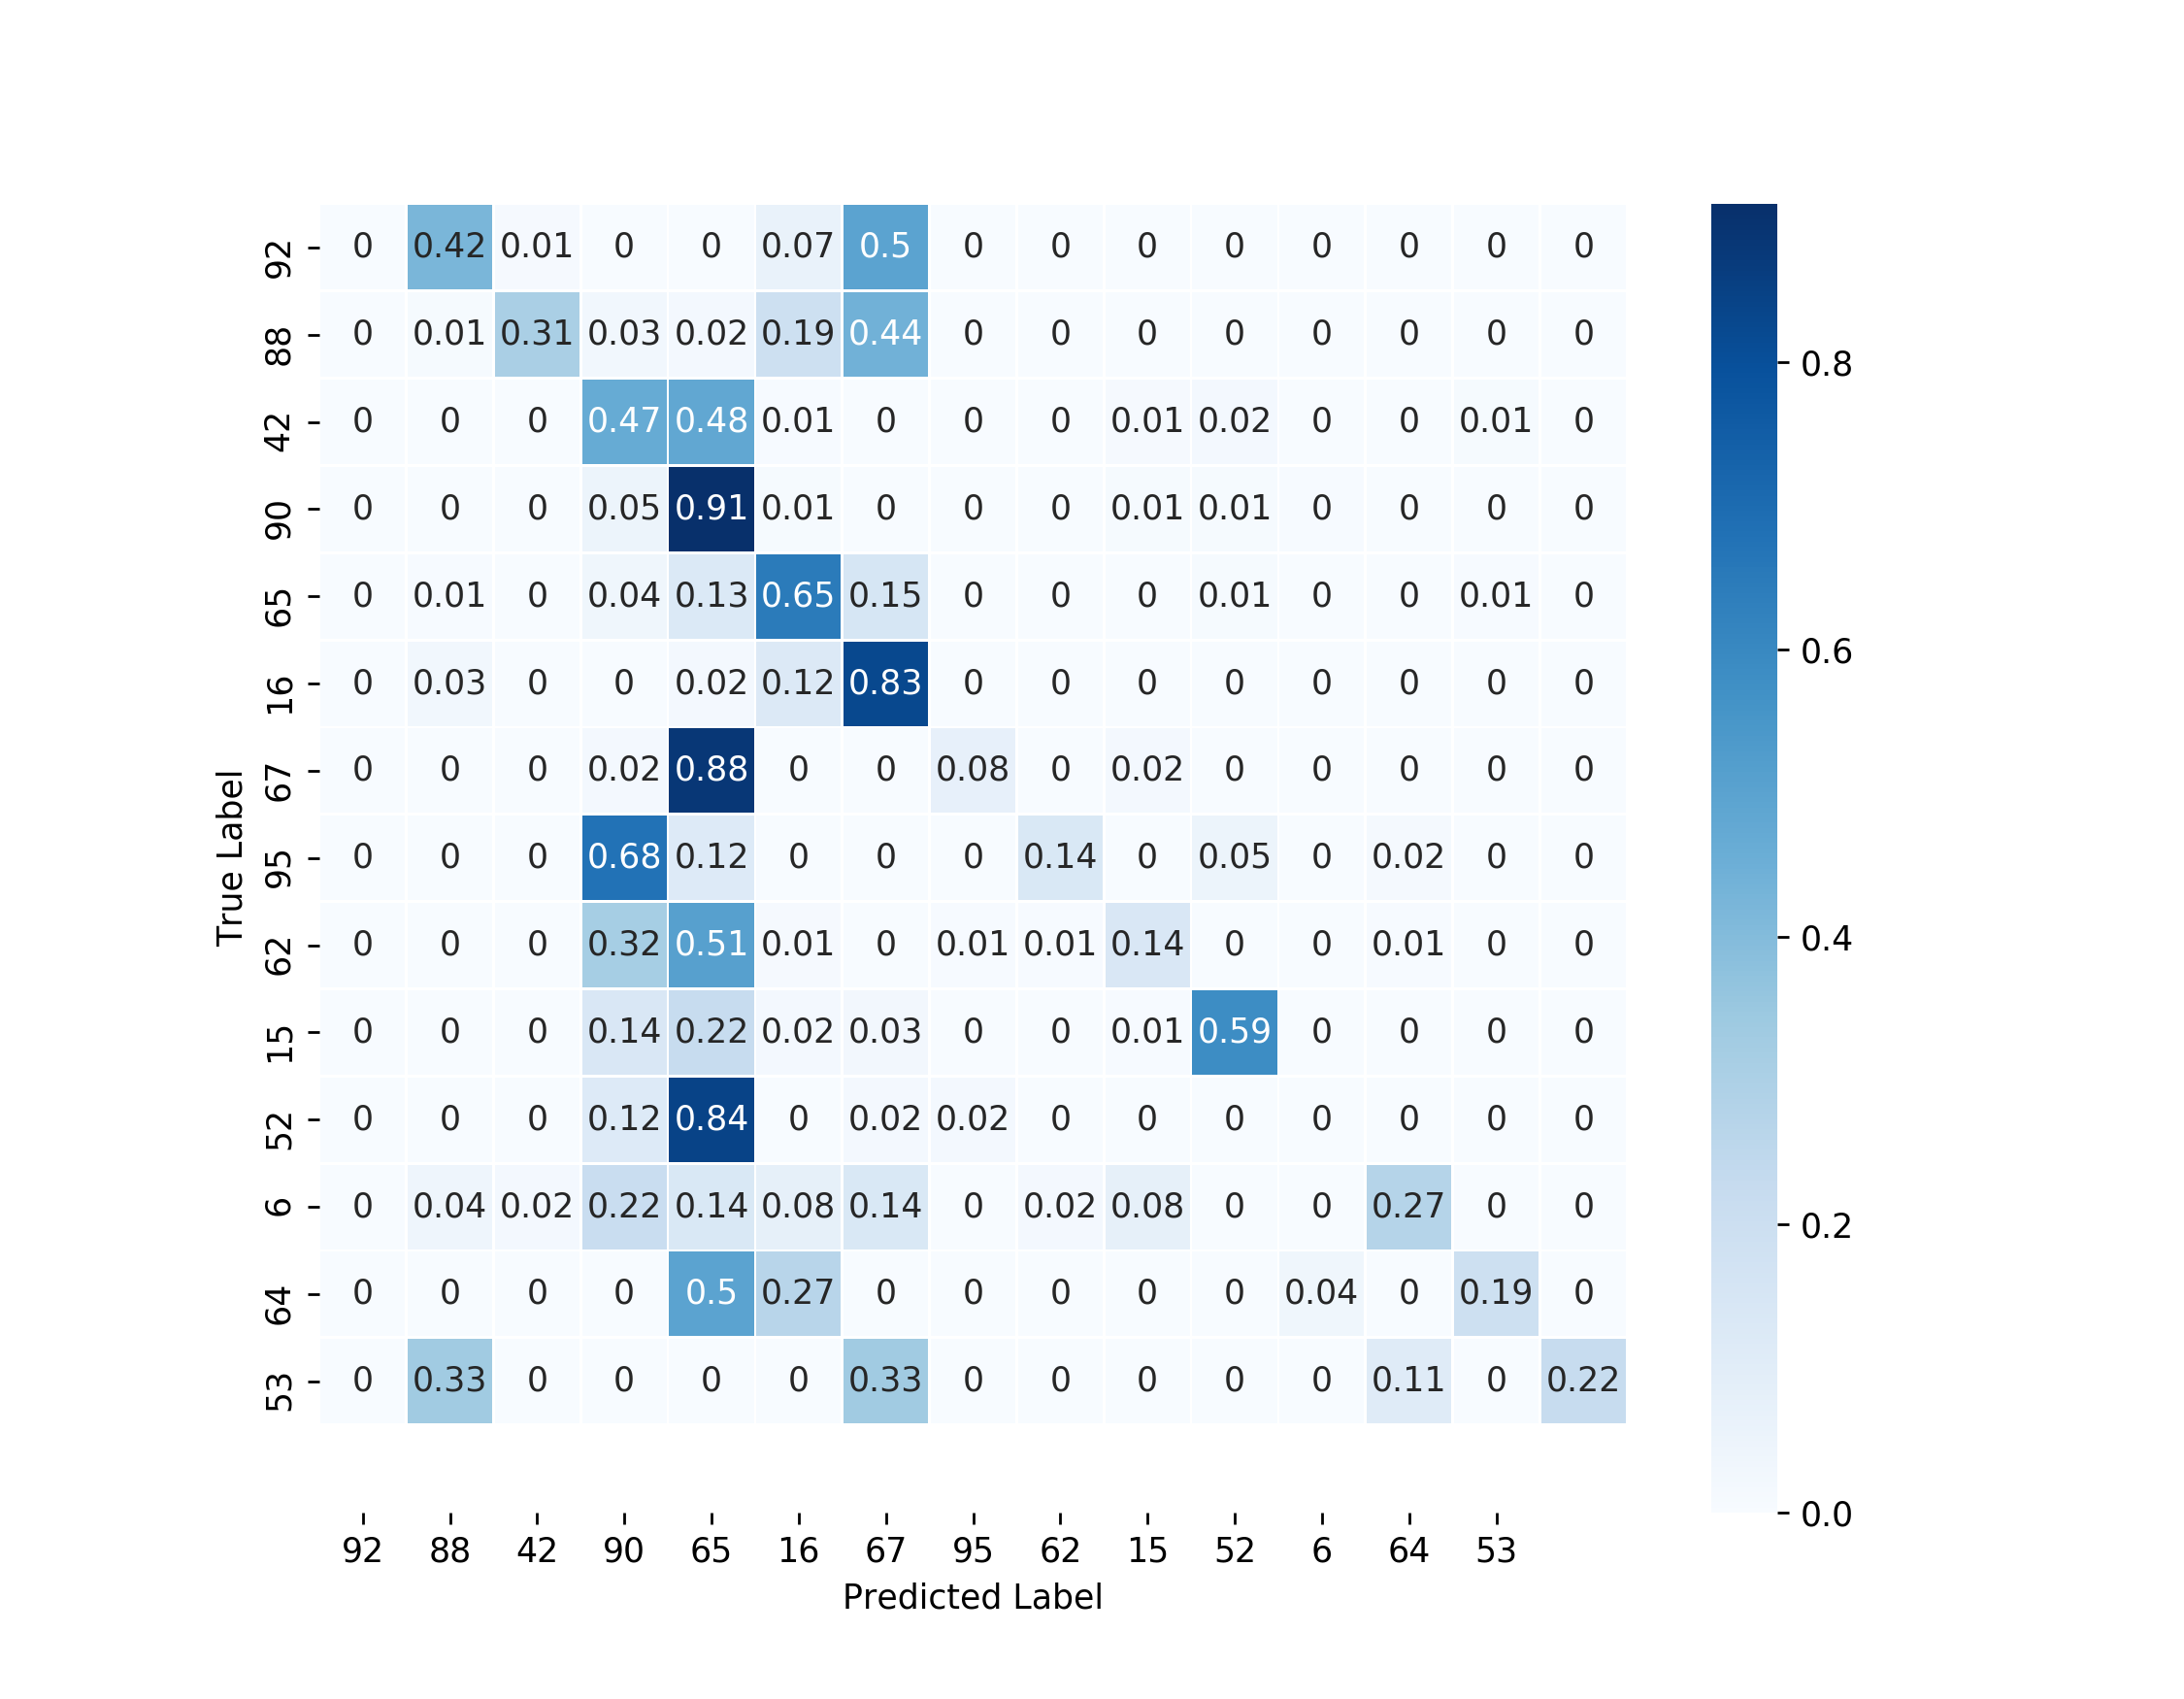

In [56]:
cm = cms[0]
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)

labels=[]
# for tp_row in unique(types, keys='Type'):
#     labels.append(tp_row['Type'])
for item in dat.dict_2_user_types.values():
    labels.append(item) 

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')

In [59]:
wavelet_features.to_pandas().head()

,Object,C0,C1,C2,C3,C4,C5,C6,C7,C8,...,C200,C201,C202,C203,C204,C205,C206,C207,C208,C209
0,61866802,-3838.665909,-23.370289,389.531403,-447.338995,198.764096,4883.270665,-1576.378018,831.261128,3064.529285,...,3.546079,-1.593200,7.665127,-13.890665,-2.961275,6.994729,-2.080307,5.435183,0.984619,-0.363728
1,90534,-6054.300643,634.789560,-67.849535,153.342589,180.646430,18.684683,216.022956,75.440973,-150.804505,...,-0.901112,0.140268,0.172928,1.683506,0.005992,-0.892394,2.308500,-2.188821,-0.853802,-0.420427
2,157477,26494.242089,-26402.617040,167.616957,-1959.565326,11042.785667,1788.822997,15848.027267,-2632.649881,3625.427106,...,-107.244414,-143.545190,-5.416159,90.586282,56.713768,-18.727096,61.364676,154.580311,61.552865,63.085322
3,42802824,11114.194541,-16116.107840,-1144.901835,-3677.814505,1338.870793,1010.247368,7204.349231,-4527.188144,4359.823073,...,72.911762,-192.184578,57.090222,-30.566860,-29.118312,-1.422281,-71.553583,-85.429854,69.806713,-103.860481
4,103802998,-2853.326475,-3227.369546,-176.068106,-121.816349,616.694605,229.369035,-411.982730,755.843925,-1026.188102,...,-13.697440,17.991907,9.668667,-15.498821,-56.024476,-4.929189,38.823685,13.527556,-5.300636,-35.195323


In [66]:
#wavelet_features.write(out_features+'/wavelet_features_train.fits')

In [69]:
import pandas as pd

In [70]:
trainFeatures = Table.read('/share/hypatia/snmachine_resources/data/plasticc/output_plasticc_no_z/features/wavelet_features_train.fits').to_pandas()

In [72]:
trainMeta = pd.read_csv('/share/hypatia/snmachine_resources/data/plasticc/training_set_metadata.csv', header=0, delimiter=',')
targetNames = trainMeta['target'].unique() # np.array with the names of the targets (only 14)

X = trainFeatures.drop('Object', axis=1)
y = trainMeta['target'].values